## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [45]:
from scipy.stats import mannwhitneyu

In [46]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [47]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df = pd.DataFrame({"x": x, "y": y})

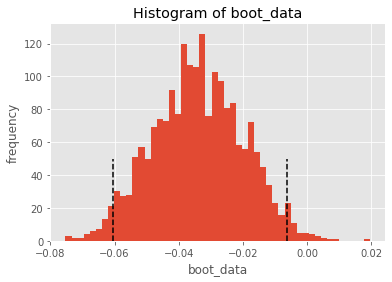

In [48]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [49]:
booted_data["p_value"]

0.015967841910844854

In [50]:
booted_data["ci"]

,0
0.025,-0.060541
0.975,-0.006225


In [51]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [52]:
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [53]:
df['value'] = df['value'].str.replace(',', '.').astype(float)
df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [54]:
df = df.drop(columns='Unnamed: 0')
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [55]:
sample_1 = df[df.experimentVariant == 'Control']
sample_2 = df[df.experimentVariant == 'Treatment']

In [56]:
sample_2

,value,experimentVariant
500,10.380495,Treatment
501,9.546867,Treatment
502,11.088215,Treatment
503,10.147274,Treatment
504,9.789808,Treatment
...,...,...
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment


In [63]:
sample_1.describe()

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


In [64]:
sample_2.describe()

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


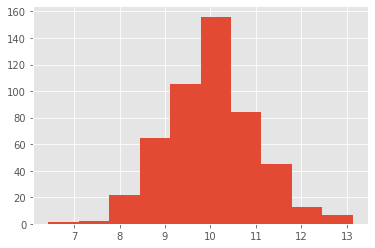

In [67]:
sample_1.value.hist()

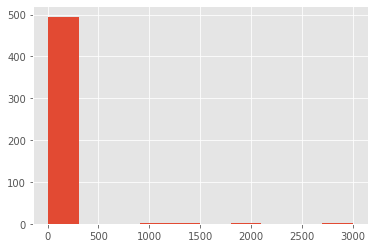

In [68]:
sample_2.value.hist()

# Bootstrap (np.mean) + mann-whitney:

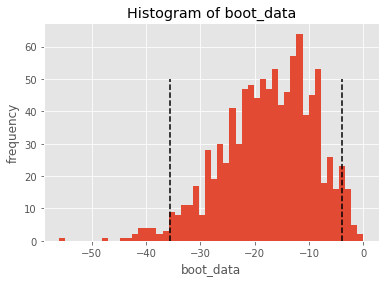

In [59]:
boot_1 = get_bootstrap(
    sample_1.value,
    sample_2.value,
    boot_it = 1000
)

In [60]:
boot_1["p_value"]

0.0383302118301072

In [61]:
mannwhitneyu(sample_1.value, sample_2.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

## Вывод:

Bootstrap дает p-value < 0.05 и таким образом позволяет отвергнуть нулевую гипотезу о равенстве средних значений выборок. То есть согласно этому методу, различие средних значений не случайно, а статистически значимо.
Если же посмотреть на результаты применения критерия Манна-Уитни, то он дал значение p-value, не позволяющее отвергнуть нулевую гипотезу.

Предполагаю, что критерий Манна-Уитни в данном случае оказался недостаточно чувствителен к значительным выбросам справа у второй выборки.

# Bootstrap (np.median):

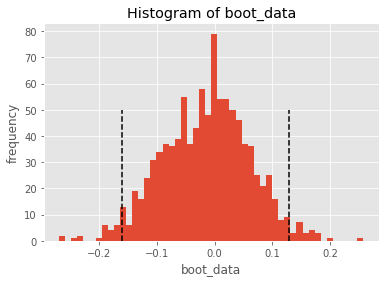

In [69]:
boot_2 = get_bootstrap(
    sample_1.value,
    sample_2.value,
    boot_it = 1000,
    statistic = np.median
)

In [70]:
boot_2["p_value"]

0.8453254813614638

## Вывод:

Если методом Bootstrap сравнивать не средние (довольно сильно различающиеся), а медианные значения двух выборок, то полученнное p-value не дает возможности отвергнуть нулевую гипотезу. И в самом деле, медианные значения выборок почти равны - 10.026 и 10.018. 

При этом полученнное p-value близко по значению к p-value по критерию Манна-Уитни. Это опять же объясняется тем, что медиана и критерий Манна-Уитни значительно менее чувствительны к редким, но крупным по модулю выбросам, чем среднее.